# Commands

In [5]:
# res$sample.param.timedep$xi
# res$sample.param.const
# res$sample.param.ou
# res$sample.logpdf

# Upgrade

In [1]:
# import libraries
library(readxl)
library(timedeppar)

Loading required package: mvtnorm



In [2]:
# import datasets
col_names <- c("Year1", "Cycle1", "blank1", "Year2", 
               "Cycle2", "blank2", "Year3", "Cycle3")
df <- read_excel("./data/syntheticData.xlsx", skip=4, 
                 col_names=col_names)
df1 <- df[,c(1,2)]
df2 <- df[,c(4,5)]
df3 <- df[,c(7,8)]

In [78]:
# log-likelihood function
loglikeli <- function(param, data) {
    # build time series from intervals
    xi <- param$xi[,2]
    t0 <- data[[1,1]]
    t <- c(t0, t0+cumsum(xi))
    
    
    # model parameters
    A <- param$A
    period <- 11 # years
    omega <- 2 * pi / period
    phi <- param$phi
    
    # harmonic signal at inferred time points
    y_model <- A * cos(omega * t + phi)
    
    # log-likelihood of observed data
    loglik <- sum(dnorm(data[[2]], mean=y_model,
                        sd=param$sigma_y, log=TRUE))
    return(loglik)
}

# initialization parameters function
initialize_params <- function(data, A=1, phi=0, sigma_y=0.1, 
                              xi_mean=1, xi_sd=0.1, xi_gamma=10) {
    
    times <- data[[1]][1:(nrow(data)-1)]
    
    # initial parameters for the harmonic model
    xi_init <- randOU(
        mean = xi_mean,
        sd = xi_sd,
        gamma = xi_gamma,
        t = times
    )
    xi_matrix <- as.matrix(cbind(times, xi_init$y))
    
    param.ini <- list(
        xi = xi_matrix,
        A = A,
        phi = phi,
        sigma_y = sigma_y
    )
    
    # initial parameters for OU processes (xi) 
    param.ou.ini = c(
        xi_mean = xi_mean,
        xi_sd = xi_sd,
        xi_gamma = xi_gamma
    )
    
    return(list(param.ini=param.ini, param.ou.ini=param.ou.ini))
}

# inference function
run_inference <- function(data, param.ini, param.ou.ini,
                         n.iter=1000, n.interval=50, n.adapt=NA) {
    
    if (!is.numeric(n.adapt)) {
        n.adapt <- 0.4 * n.iter
    }
    
    res <- infer.timedeppar(
        loglikeli = loglikeli,
        data = data,
        param.ini = param.ini,
        param.ou.ini = param.ou.ini,
        param.range = list(
            A = c(1, 10),
            phi = c(0, 2*pi),
            sigma_y = c(0.01, 10),
            xi = c(0.1, 2),
            xi_mean = c(-10, 10),
            xi_sd = c(0.01, 10),
            xi_gamma = c(1, 20)
        ),
        param.log = c(
            A = FALSE,
            phi = FALSE,
            sigma_y = TRUE,
            xi = TRUE
        ),
        n.iter = n.iter,
        control = list(
            n.interval = n.interval,
            n.adapt = n.adapt
        ),
        verbose = 0
    )
}

infer.timedeppar (timedeppar 1.0.3 2023-08-28): starting new Markov Chain

  number of constant parameters:          3

  number of time-dependent parameters:    1

  number of estimated process parameters: 3

50000 iterations completed

  acceptance frequency of constant parameters:             0.106

  acceptance frequencies of time-dependent parameters:     0.0356

  acceptance frequencies of Ornstein-Uhlenbeck parameters: 0.238

plot.timedeppar (timedeppar 1.0.3 2023-08-28): plotting inference results: traces,marginals,summary,pairs,time-series,accept



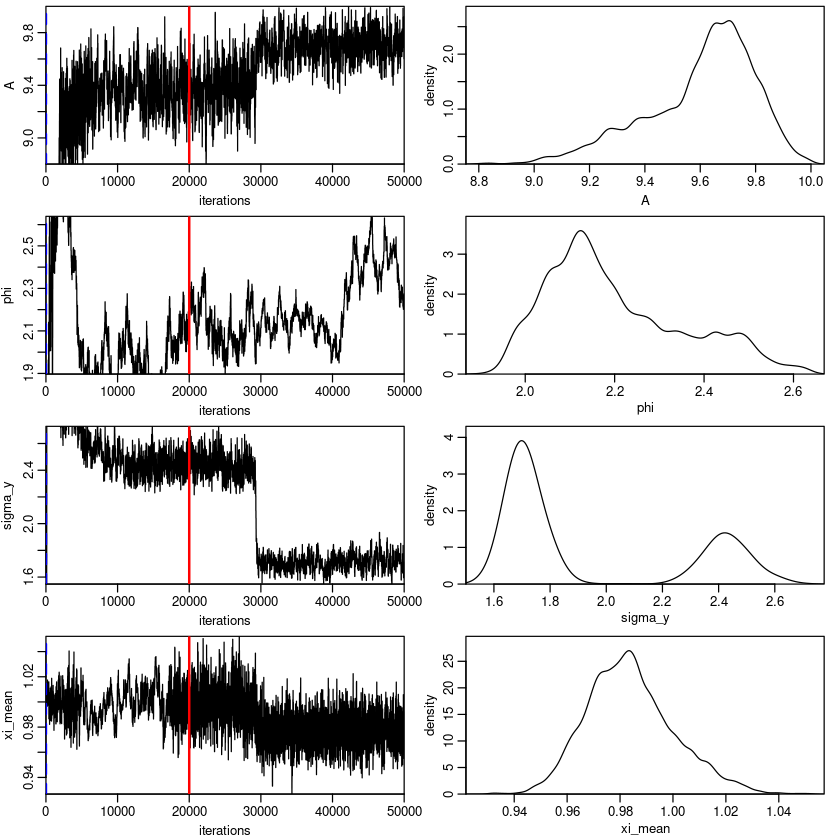

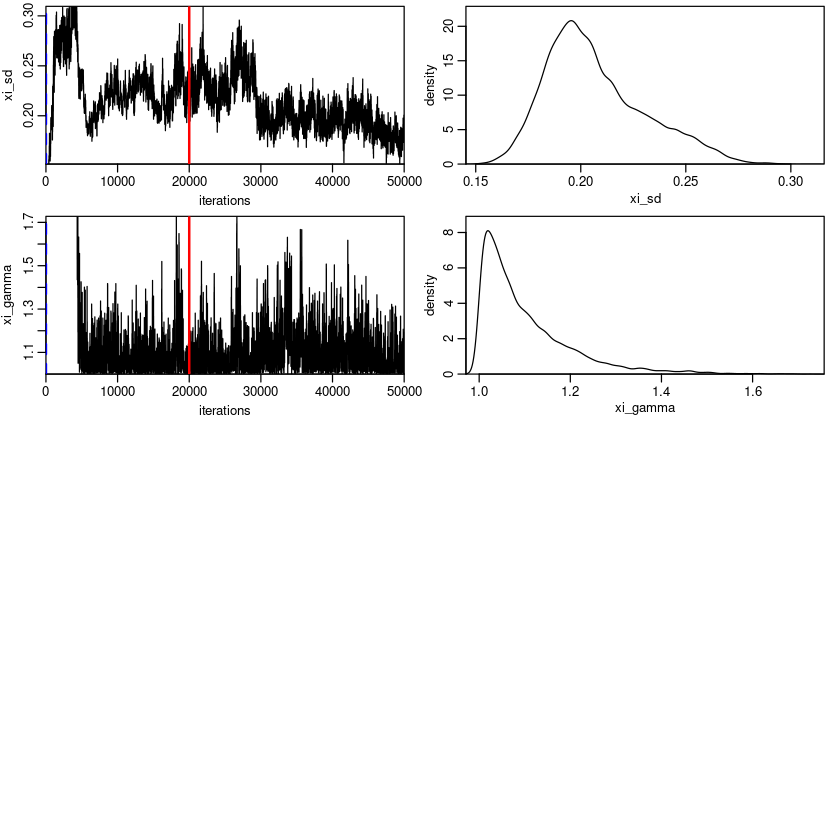

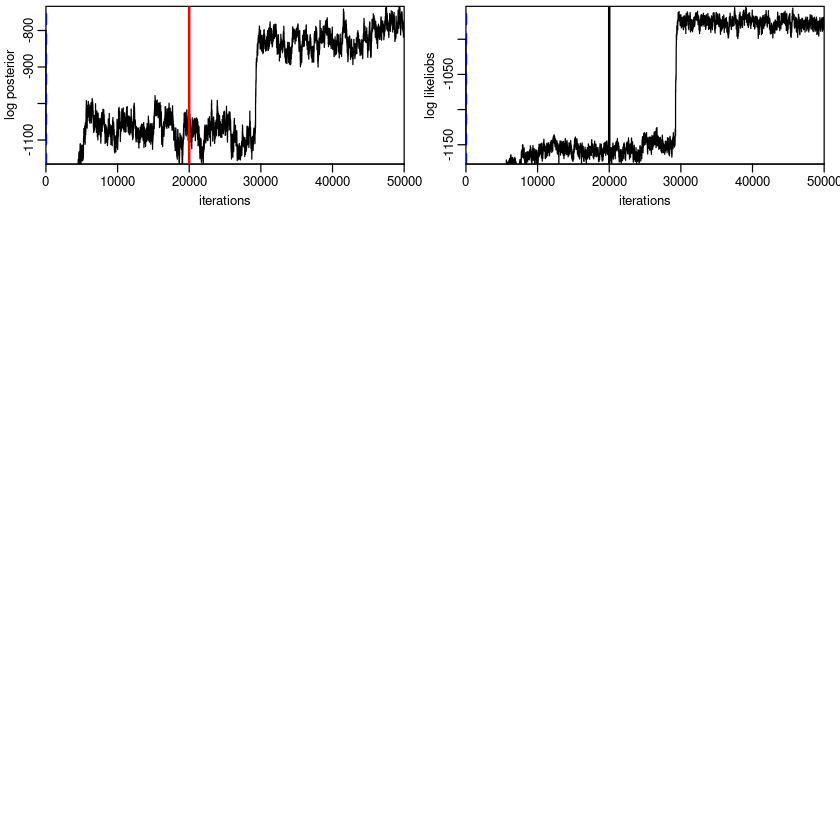

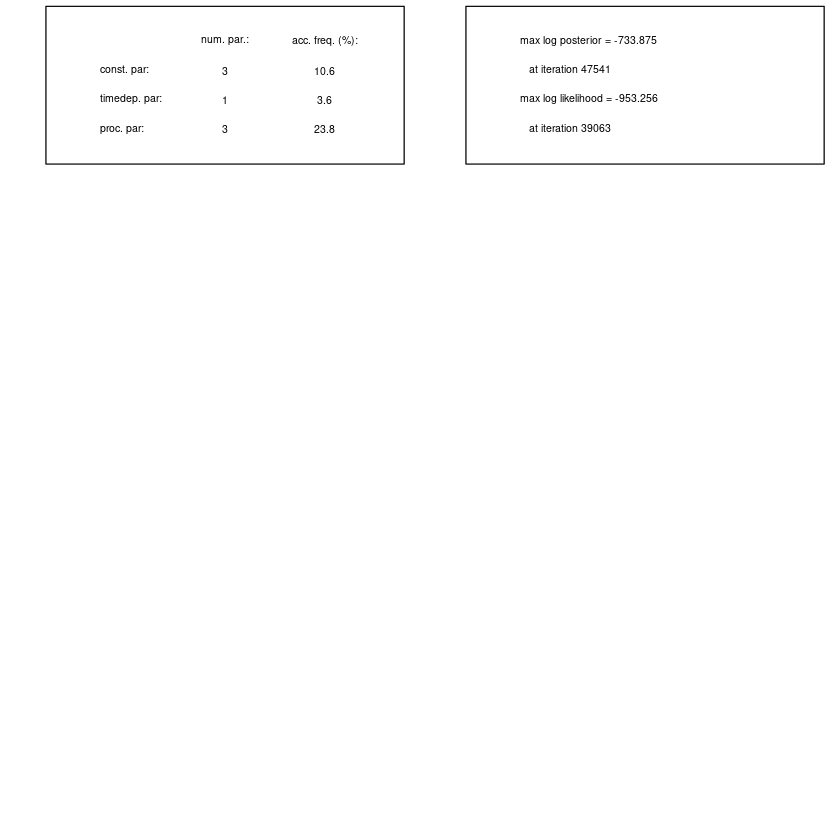

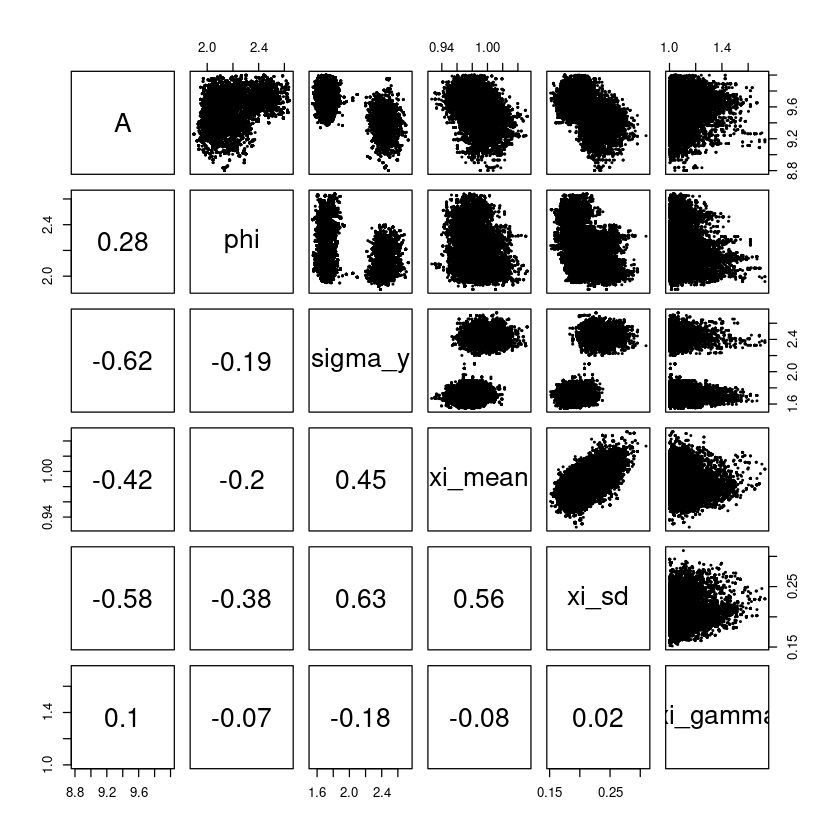

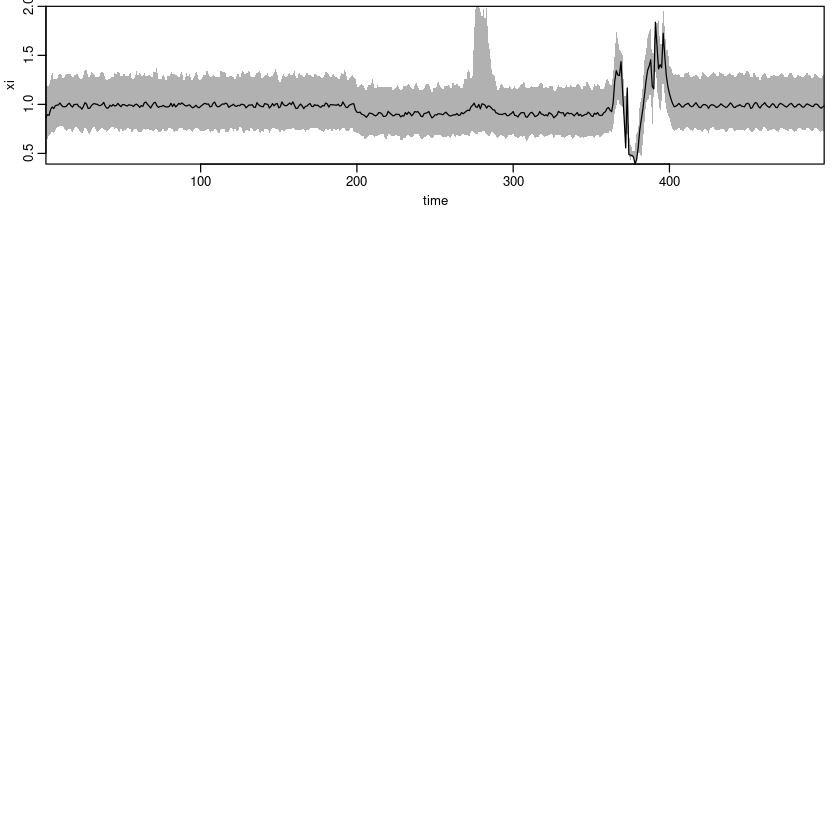

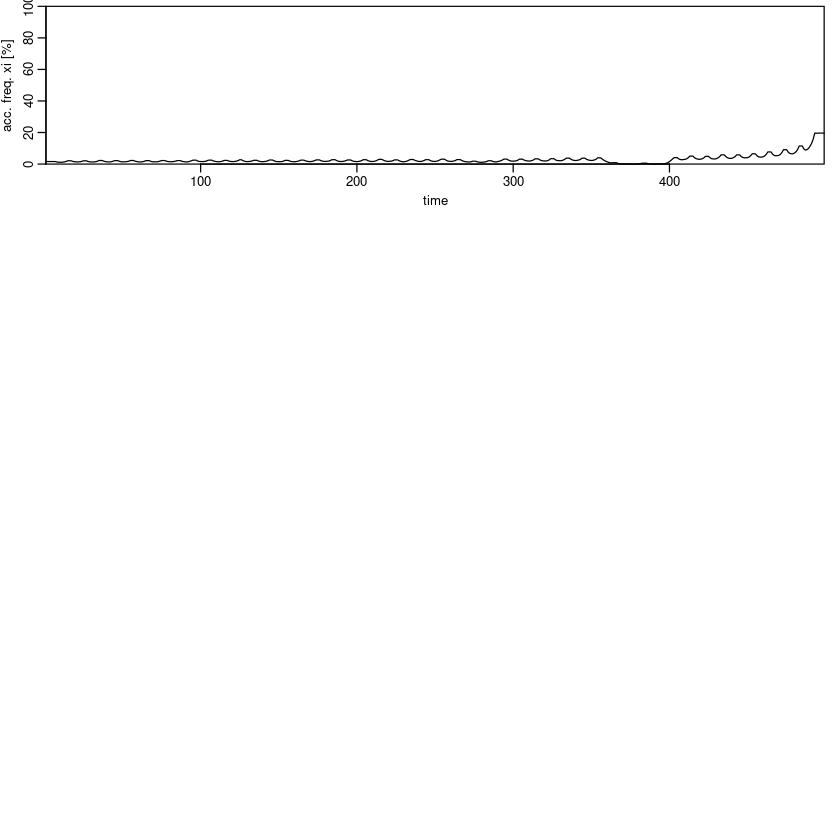

In [79]:
data = df3
params <- initialize_params(
    data,
    xi_sd = 0.1,
    xi_gamma = 10
)
res <- run_inference(
    data, 
    params$param.ini, 
    params$param.ou.ini,
    n.iter = 50000,
    n.interval = 25,
    n.adapt = 20000
)
plot(res)

In [ ]:
# TODO: add the possibility to check the status in the loop